In [62]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.optimize as opt

import models_fit

import emcee
% matplotlib inline

In [34]:
def func(x, a, b, c):
    return a+b*x+c*x**2

In [53]:
c1 = 10
c2 = 3
c3 = 10

xdata = np.linspace(0,1, 100)

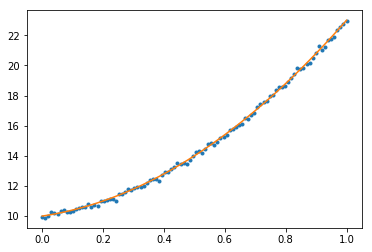

In [56]:
noise = np.random.normal(0, 1e-1, len(xdata))
ydata = func(xdata, c1, c2, c3)


plt.plot(xdata, ydata+noise,'.')
plt.plot(xdata, ydata)

In [60]:
b = 3
popt, pcov = opt.curve_fit(lambda x, a,c:func(x,a,b,c), xdata, ydata+noise)

In [61]:
popt

array([9.99093081, 9.99538051])

In [ ]:
class orb_params()

In [69]:
# Some variable def
r_star            = 1.377              # for XO-3 in solar radius
r_sol2jup         = 0.10049            # jupiter radius in solar radius
r_sol2AU          = 214.93946938       # AU radius in solar radius
hrs2days          = 1/24.0             # hour in days

t0   = 1.97                      # BMJD time
per  = 3.1915239                       # in days
rp   = 0.125/r_star                    # radius (in solar radius)/stellar radius (solar radius) 
a    = 0.0454*r_sol2AU/r_star          # 
inc  = 84.20                           # 90 = edge-on                
ecosw= 0.277*np.cos(np.deg2rad(347.2)) # ecc and w from (Wong et aL. 2014) # np.cos only takes rad
esinw= 0.277*np.sin(np.deg2rad(347.2)) # ecc and w from (Wong et aL. 2014) # np.sin only takes rad
q1   = 0.001
q2   = 0.001
fp   = 0.0015                           # eclipse depth in units of stellar flux

# Phase Variation Parameters (2 params)
A    = 0.1
B    = 0.0

# pre-calculation
mid_x = 15.1
mid_y = 15.2

# photometric scatter
sigmaf = 0.01

In [70]:
time = np.linspace(0.4, 4.4, 1000)

astro = models_fit.phase_curve(time, t0, per, rp, a, inc, ecosw, esinw, q1, q2, fp, A, B)
noise = np.random.normal(0, 5e-4, len(astro))

signal = astro+noise

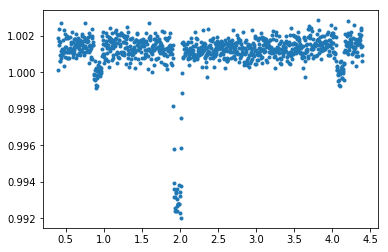

In [71]:
plt.plot(time, signal,'.')

In [84]:
#Log likelihood function
def lnlike(p0, time, flux):
    # unpack p0
    t0, per, rp, a, inc, ecosw, esinw, q1, q2, fp, A, B, flux_err = p0
    # define model
    model = models_fit.phase_curve(time, per, t0, rp, a, inc, ecosw, esinw, q1, q2, fp, A, B)
    inv_sigma2 = 1.0/(flux_err**2)
    return -0.5*(np.sum((flux-model)**2*inv_sigma2) - len(flux)*np.log(inv_sigma2))

# Probability distribution to draw sample from
def lnprior(p0):
    t0, per, rp, a, inc, ecosw, esinw, q1, q2, fp, A, B, flux_err = p0
    if (1.5< t0 < 2.5 and 0 < rp < 1  and 0 < fp < 1 and 
        0 < q1 < 1 and 0 < q2 < 1):
        return 0.0 
    return -np.inf

# Total probability function
def lnprob(p0, time, flux):
    lp = lnprior(p0)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(p0, time, flux)

In [85]:
p0 = np.array([t0, per, rp, a, inc, ecosw, esinw, q1, q2, fp, A, B, sigmaf])

In [86]:
ndim, nwalkers, nstep = len(p0), 2*len(p0), 20 
pos = [p0 + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(time, signal))

In [87]:
pos, lnpro, state, = sampler.run_mcmc(pos, nstep)